# Classification of Monoaminergic Neurons of Drosophila Melanogaster into Sub-types

The dataset of Thirsty Flies was obtained as part of a study of the cellular changes in the brain of *Drosophila melanogaster* (fruit fly) triggered by water deprivation ([link to paper](https://www.sciencedirect.com/science/article/pii/S0960982222011757)). The authors of the study were observing water-seeking behavior and obtained gene expression data via single-cell sequencing in four settings: when the flies were sated, when they have been deprived of water for $6$ hours, when they have been deprived of water for $12$ hours, and $45$ minutes after they have been rehydrated after having been deprived of water for $12$ hours.

The union of these data was split into seven classes of brain cells based on the prior knowledge of which gene codes for which type of a brain cell. Five of the labeled classes, namely the **cholinergic, glutamatergic, GABAergic neurons, Kenyon cells and glia \& astrocytes**, have been clustered further. However, when trying to do the same for the smallest labeled class, monoaminergic neurons, the same clustering pipeline struggled to produce coherent clusters, likely due to the comparatively small number of monoaminergic neurons.

<img src="Images/drosophila_braincells_clustering.png" width="840" alignment="center"/>

In this notebook, we analyze the monoaminergic neurons only. 
> Monoamine is a compound that contains one amino group connected to an aromatic ring by a two-carbon chain, and acts as a neurotransmitter in monoaminergic neurons. In mammals, the most common monoamine neurotransmitters are dopamine, epinephrine, norepinephrine and serotonin. In insects (such as drosophila), however, epinephrine and norepinephrine (known also as adrenaline and noradrenaline) are synthesized only in trace amounts. Instead, monoamines tyramine and octopamine are much more prevalent, and they replace epinephrine and norepinephrine in their role as adrenergic transmittors. They have many roles including in regulating behavior, sensory processing, locomotion and metabolism.

We wish to understand several levels of its heterogeneity, beginning with classifying the neurons into four known subtypes, namely the **dopaminergic**, **serotoninergic**, **tyaminergic** and **octopaminergic neurons**. We will use $k$-means, spectral clustering, Louvain algorithm for community detection, and $k$-cluster for clustering and custom defined methods to understand cluster separation.

## I. The Data Set

In [2]:
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning)
warnings.filterwarnings(action='ignore', category=UserWarning)
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

In [3]:
import pickle
M, iM_og, genes, neurons, important_genes, important_genes_ids, experiments, experiment_labels, _, _ = pickle.load(open("Pickle/main_info.p", "rb"))
exec(open("clustering_methods.py").read())

/home/ziva/miniconda3/envs/monoaminergic/lib/python3.8/site-packages/umap/plot.py:203: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit(nopython=False)


<Figure size 640x480 with 0 Axes>

The data set is stored as a $765 \times 9859$ matrix $M$, where each row is a gene expression vector of a monoaminergic neuron. The entry $M(i, j)$ is an integer signifying the strength of expression of $j$-th gene in $i$-th neuron.

In [4]:
print(M[:10, :10])

[[13  0  0  0  0  2  0  5  5  2]
 [ 0  2  0  0  0  1  1  3  4  2]
 [ 0  1  0  0  0  9  2  6  5  1]
 [ 2  1  0  0  0  1  1  1  1  0]
 [ 9  0  0  0  0  2  0  1  3  1]
 [ 5  0  0  0  0  2  0  0  3  1]
 [17  4  0  0  0  1  6  3  2  2]
 [ 0  1  0  0  0  1  1  0  1  0]
 [ 0  0  0  0  0  7  2  0  0  0]
 [ 0  8  0  0  0 11  4  9  5  1]]


Names of genes (columns) and IDs of neurons are saved in lists `genes` and `neurons`, respectively.

In [5]:
print("Names of genes:", *genes[:10],"...")
print("IDs of neurons:", *neurons[:5],"...")

Names of genes: mCherry Myo81F CR12798 lncRNA:CR46122 Pzl Parp Alg-2 Tim17b CG41128 CG41099 ...
IDs of neurons: sat00_rep1_ACTACGAAGGTCGTAG.1 sat00_rep1_ACTCCCAAGACTCTAC.1 sat00_rep1_AGCCAGCCAAGGTACG.1 sat00_rep1_AGCTTCCGTGTCATCA.1 sat00_rep1_AGTAGTCTCAGCGGAA.1 ...


The genes (columns) are not ordered in any particular way, whereas the order of neurons is as follows:
 * first $153$ rows (rows $1$ to $153$) belong to neurons of sated flies (tagged with `sat00`),
 * next $204$ rows (rows $154$ to $357$) belong to neurons of flies that have been dehydrated for $6$ hours (tagged with `dep06`),
 * next $202$ rows (rows $358$ to $559$) belong to neurons of flies that have been dehydrated for $12$ hours (tagged with `dep12`),
 * last $206$ rows (rows $560$ to $765$) belong to neurons of flies that have first been dehydrated for $12$ hours and then rehydrated (tagged with `reh00`).

In [6]:
print(*[neurons[id][:5] for id in [0, 153, 357, 595]])

sat00 dep06 dep12 reh00


## II. Four Subtypes of Monoaminergic Neurons

Some genes (or rather a combination of them) are known to code for a specific neurotransmitter:
 * High expression of genes `ple` and `DAT` suggests that the neuron in specialized for **dopamine**.
 * High expression of genes `SerT` and `Trh` suggests that the neuron in specialized for **serotonin**.
 * High expression of genes `Tdc2` and `Tbh` suggests that the neuron in specialized for **octopamine**.
 * High expression of gene `Tdc2` and low expression of gene `Tbh` suggests that the neuron in specialized for **tyramine**
These six listed genes together with another gene, `Fer2`, that identifies a large subtype of dopaminergic neurons, are considered to be important for the classification task at hand. They are referred to as **important genes**, and denote the restriction of $M$ to the columns of important genes as `iM`.

In [7]:
iM = np.copy(iM_og)

print("Names of important genes:  ", *important_genes)
print("Indices of important genes:", *important_genes_ids)
print(iM[:10, :])

Names of important genes:   Fer2 Trh ple Tdc2 DAT SerT Tbh
Indices of important genes: 1082 2471 2907 4429 5433 6191 6889
[[  3   0  61   0  52   0   0]
 [  0  54   0   0   0  18   0]
 [  0  98   0   0   0  51   0]
 [  3   0  40   0  25   0   0]
 [  4   0  29   0  29   0   0]
 [  3   0  29   0  39   0   0]
 [  4   0  59   0  80   0   1]
 [  0   6   1   0   0  13   0]
 [  0   0  18   0 115   0   0]
 [  0   0 285   0 147   0   0]]


Let $\mu = [\mu_1, \ldots, \mu_7]$ be the vector of mean expression for each important gene in the order they appear in as the columns of $iM$. Then a list of **class representatives** can be comprised for each expected class based on how a neurons expression pattern compares with $\mu$. For example, neurons whose expression of `ple` and `DAT` is higher than the corresponding mean while the expression of all other genes is $0$ are identified as dopaminergic class representatives. Luckily, no neuron is identified as a representative for more than one class.

In [8]:
representatives, neurons_in_multiple_classes = get_representatives(iM, np.mean(iM, axis=0), exclusive=True)
print("Number of neurons belonging to multiple classes:", len(neurons_in_multiple_classes))
for key in representatives:
    print("There are", len(representatives[key]), "representatives of class", key, ":", *representatives[key][:10], "...")

Number of neurons belonging to multiple classes: 0
There are 97 representatives of class Dopamine : 0 9 14 19 21 35 50 56 62 67 ...
There are 55 representatives of class Serotonin : 1 2 12 31 68 76 77 94 117 175 ...
There are 31 representatives of class Octopamine : 85 102 119 133 157 201 213 238 240 265 ...
There are 31 representatives of class Tyramine : 80 91 131 132 138 189 215 218 226 246 ...


The below code produces plot annotations we use later to keep track of class representatives.

In [9]:
annotations, legend_text = get_plot_annotations(representatives)
for key in legend_text.keys():
    txt = legend_text[key]
    legend_text[key] = txt[8:]

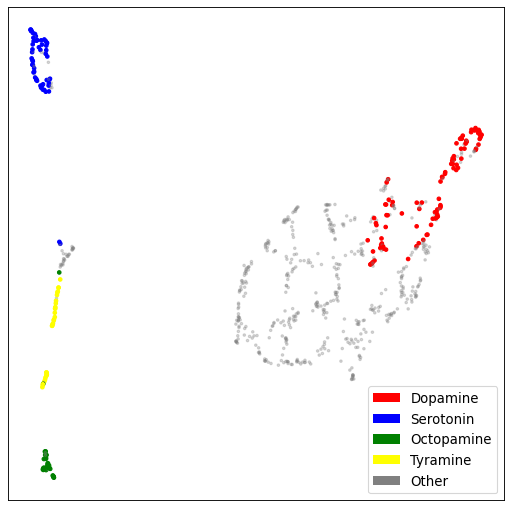

In [10]:
mapper = umap.UMAP(random_state=2400).fit(iM)

c = ["gray"]*len(iM[:,0])
s = [5]*len(iM[:,0])
alpha = [0.3]*len(iM[:,0])
colors = ['red', 'blue','green','yellow', 'gray']
texts = list(representatives.keys()) + ["Other"]
plt.figure(figsize=(8,8), dpi=80)
for i, key in enumerate(representatives.keys()):
    for j in representatives[key]:
        c[j]=colors[i]
        s[j]=10
        alpha[j]=1
plt.scatter(*mapper.embedding_.T, c=c, s=s, alpha=alpha)
#visualize_umap(mapper, [0]*len(iM[:,0]), c='gray')
plt.tick_params(left = False, right = False, labelleft = False, labelbottom = False, bottom = False) 
legend1_elts = [Patch(facecolor=colors[i], label=texts[i]) for i in range(5)]
plt.legend(handles=legend1_elts, loc=4, fontsize=12)

### II.1 Clustering on $iM$ with euclidean distance

To choose the number of naturally present clusters within the data set according to $k$-cluster filtration for $k=8$, we cluster once using `visualize_kcluster` method (the value of $k$ should be passed as `n_neighbors` parameter). The method returns the associated persistence diagram as the third output. From it, we compute the multiplicative values and plot them.

Constructed the distance matrix.
Constructed kcluster PD.
Clustered.


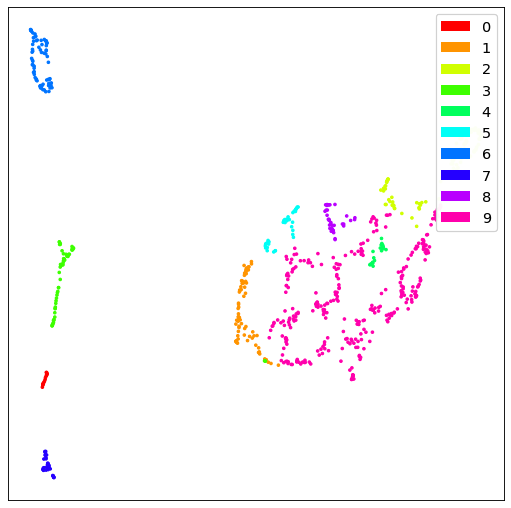

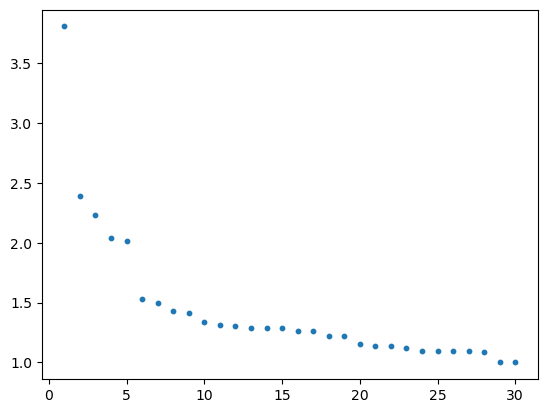

In [11]:
cluster_test, mapper, PD, _ = visualize_kcluster(iM, n_clusters=10, n_neighbors=8, metric='euclidean')
xs = range(1,len(PD))
ys = sorted([entry[1]/entry[0] for entry in PD])[::-1]           # Compute the multiplicative values for each entry
plt.scatter(xs, (ys[1:]), s=10)                                  # Plot the multiplicative values

We plot each multiplicative value against its position in the ordered list, skipping multiplicative value $\infty$, which would be first in the order. First five points (and $\infty$) are significantly higher than the rest, suggesting $iM$ has $6$ inherently present components with respect to euclidean distance.

Thus, we ask all methods (that take the desired number of clusters as input) to return $6$ clusters on $iM$ with euclidean distance. The method obtaining clustering results for all tested methods and visualizing them in a shared plot is defined here and reused later.

In [12]:
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering as SC
from cdlib import algorithms
#import community
import networkx as nx
from scipy.spatial.distance import pdist, squareform
cmap = plt.cm.get_cmap('hsv')

def four_methods(matrix, metric='euclidean', n_clusters=8, k=8, resolution=1.01, loc_clusterlegend=4, loc_replegend=1, normalized=False):
    mapper = umap.UMAP(random_state=2400, metric=metric).fit(matrix)
    DM = squareform(pdist(matrix, metric=metric))
    _, axes = plt.subplots(2,2,figsize=(15,16))

    # KMeans
    kmeans_M = np.copy(matrix)
    if metric=='cosine':
        for i,row in enumerate(np.copy(matrix)):
            kmeans_M[i,:] = 1/np.linalg.norm(row) * row
    est = KMeans(n_clusters=n_clusters,random_state=2400)
    est.fit(kmeans_M)
    labels=est.labels_
    visualize_umap(mapper, labels, annotate=annotations, legend_text=legend_text, 
                   loc_clusterlegend=loc_clusterlegend, loc_replegend=loc_replegend,
                   title="$k$-means",axis=axes[0,1])

    # Spectral Clustering
    sc = SC(n_clusters=n_clusters, n_neighbors=k, assign_labels='kmeans', affinity='precomputed_nearest_neighbors',random_state=2400).fit(DM)
    visualize_umap(mapper, sc.labels_, annotate=annotations, legend_text=legend_text, 
                   loc_clusterlegend=loc_clusterlegend, loc_replegend=loc_replegend,
                   title = "SpectralClustering",axis=axes[1,0])

    # Louvain
    weights = DM.copy()
    if not normalized:
        weights = np.log10(1+weights)
    weights = weights.max() - weights
    G = nx.from_numpy_array(weights)
    coms = algorithms.louvain(G, weight='weight', resolution=resolution, randomize=False)
    cluster_ids = np.zeros(DM[0,:].shape)
    for comid, clstr in enumerate(coms.communities):
        for i in clstr:
            cluster_ids[i] = comid
    cluster_ids = cluster_ids.astype(int)
    visualize_umap(mapper, cluster_ids, annotate=annotations, legend_text=legend_text, 
                   loc_replegend=loc_replegend, loc_clusterlegend=loc_clusterlegend,
                   title = "Louvain algorithm",axis=axes[1,1])

    # Kcluster
    cluster_ids, _, _ = compute_kcluster(matrix, n_clusters, n_neighbors=k, metric=metric, distance_matrix=DM)
    visualize_umap(mapper, cluster_ids, annotate=annotations, legend_text=legend_text, 
                   loc_replegend=loc_replegend, loc_clusterlegend=loc_clusterlegend,
                   title = "$k$-cluster",axis=axes[0,0])
    plt.subplots_adjust(wspace=0,hspace=0.1)

Note: to be able to use all crisp methods, you need to install some additional packages:  {'graph_tool', 'bayanpy', 'infomap', 'wurlitzer'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'pyclustering', 'ASLPAw'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'infomap', 'wurlitzer'}


This method, `four_methods`, takes the following input:
* `matrix`: the count matrix with gene expression values.
* `metric`: the metric in which distances between neurons should be computed (default `'euclidean'`).
* `n_clusters`: number of desired clusters for methods to output (default $8$).
* `k`: number of neighbors to take into account, same parameter as in $k$-cluster and $k$-means (default $8$).
* `resolution`: resolution parameter of Louvain community detection method (default 1.01).
* `loc_clusterlegend`: matplotlib location to display the legend for cluster coloring (default $4$).
* `loc_replegend`: matplotlib location to display the legend for annotations of the representatives (default $1$).
* `normalized`: a flag signaling whether or not data has been $log$-transformed (default `False`).

Let us obtain the clustering results on $iM$ with respect to euclidean distance.

Constructed kcluster PD.
Clustered.


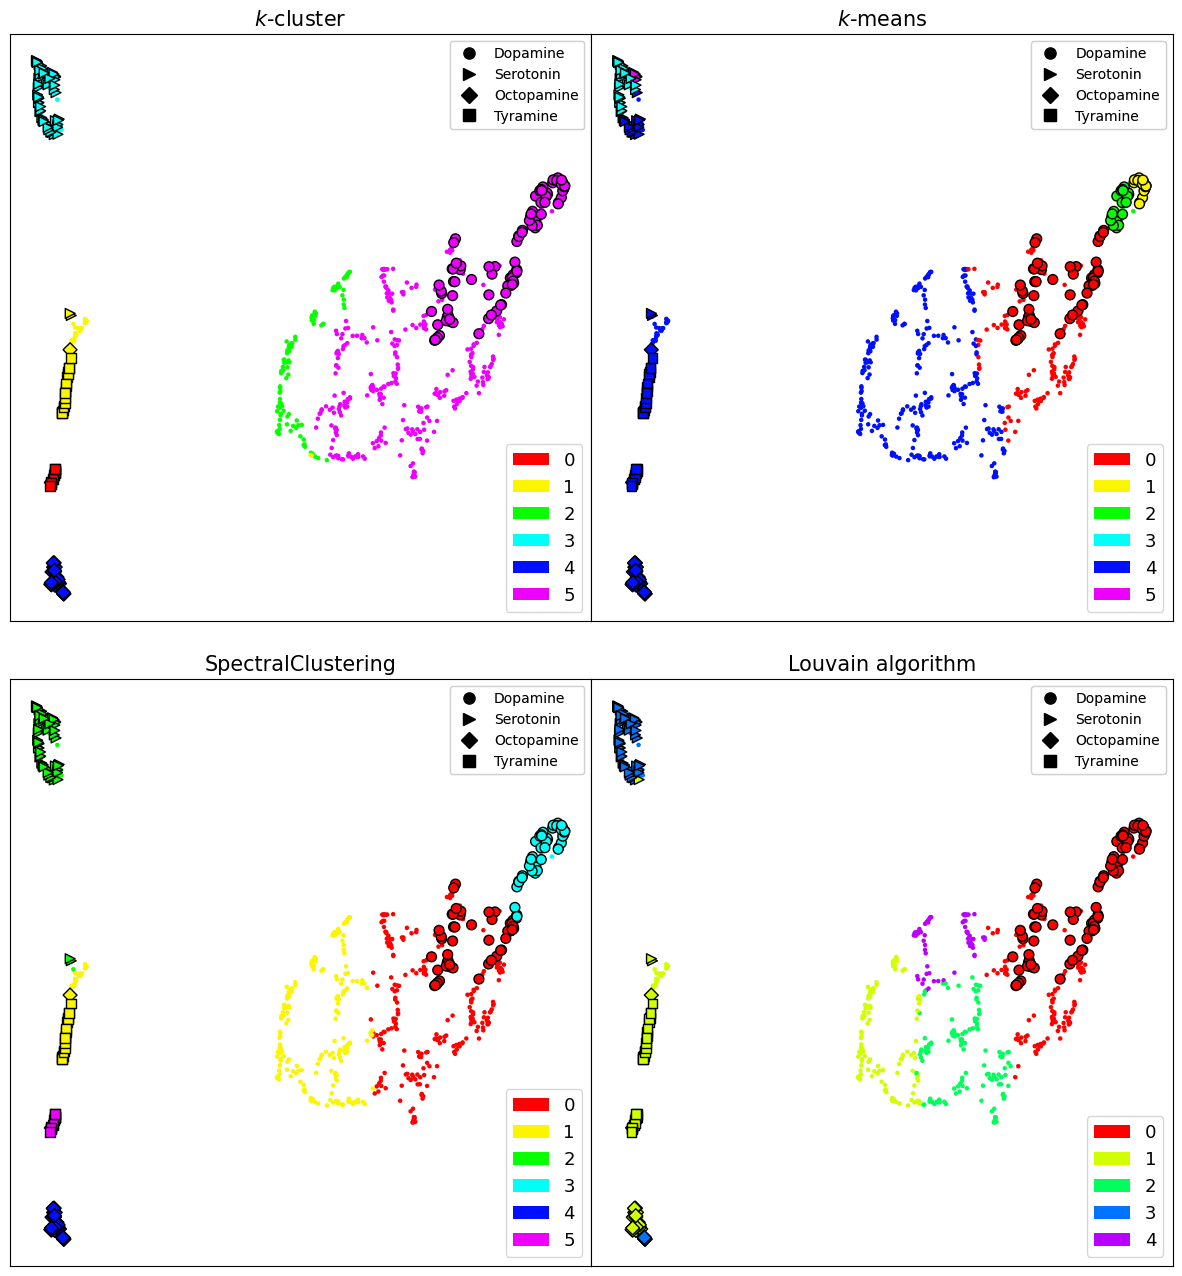

In [13]:
four_methods(iM, metric='euclidean', n_clusters=6, k=8)

### II.2 Clustering on $iM$ with cosine distance

Again, to choose the number of naturally present clusters within the data set according to $k$-cluster filtration for $k=8$, we cluster once using `visualize_kcluster` method and use the persistence diagram from the output to compute and visualize the multiplicative values.

Constructed the distance matrix.
Constructed kcluster PD.
Clustered.


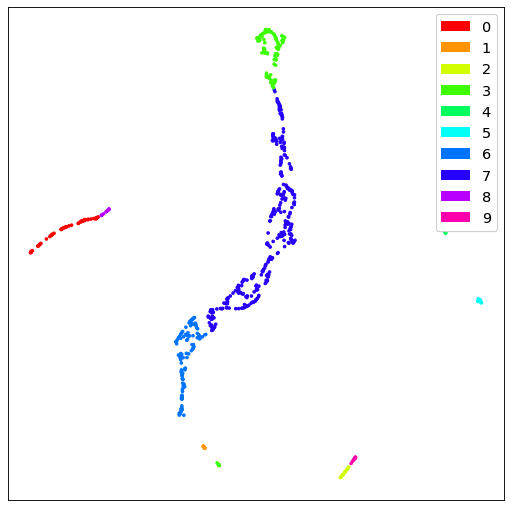

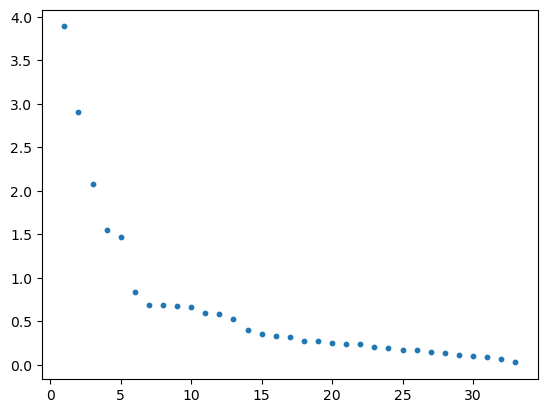

In [14]:
_, mapper_cos, PD, _ = visualize_kcluster(iM, n_clusters=10, n_neighbors=8, metric='cosine')
xs = range(1,len(PD))
ys = sorted([entry[1]/entry[0] for entry in PD])[::-1]           # Compute the multiplicative values for each entry
plt.scatter(xs, np.log10(ys[1:]), s=10)                                  # Plot the multiplicative values

We plot the $\log_{10}$ of each multiplicative value against its position in the ordered list, skipping multiplicative value $\infty$, which would be first in the order. First five points (and $\infty$) are significantly higher than the rest, suggesting $iM$ has $6$ inherently present components with respect to cosine similarity.

Thus, we ask all methods (that take the desired number of clusters as input) to return $6$ clusters on $iM$ with cosine similarity.

Constructed kcluster PD.
Clustered.


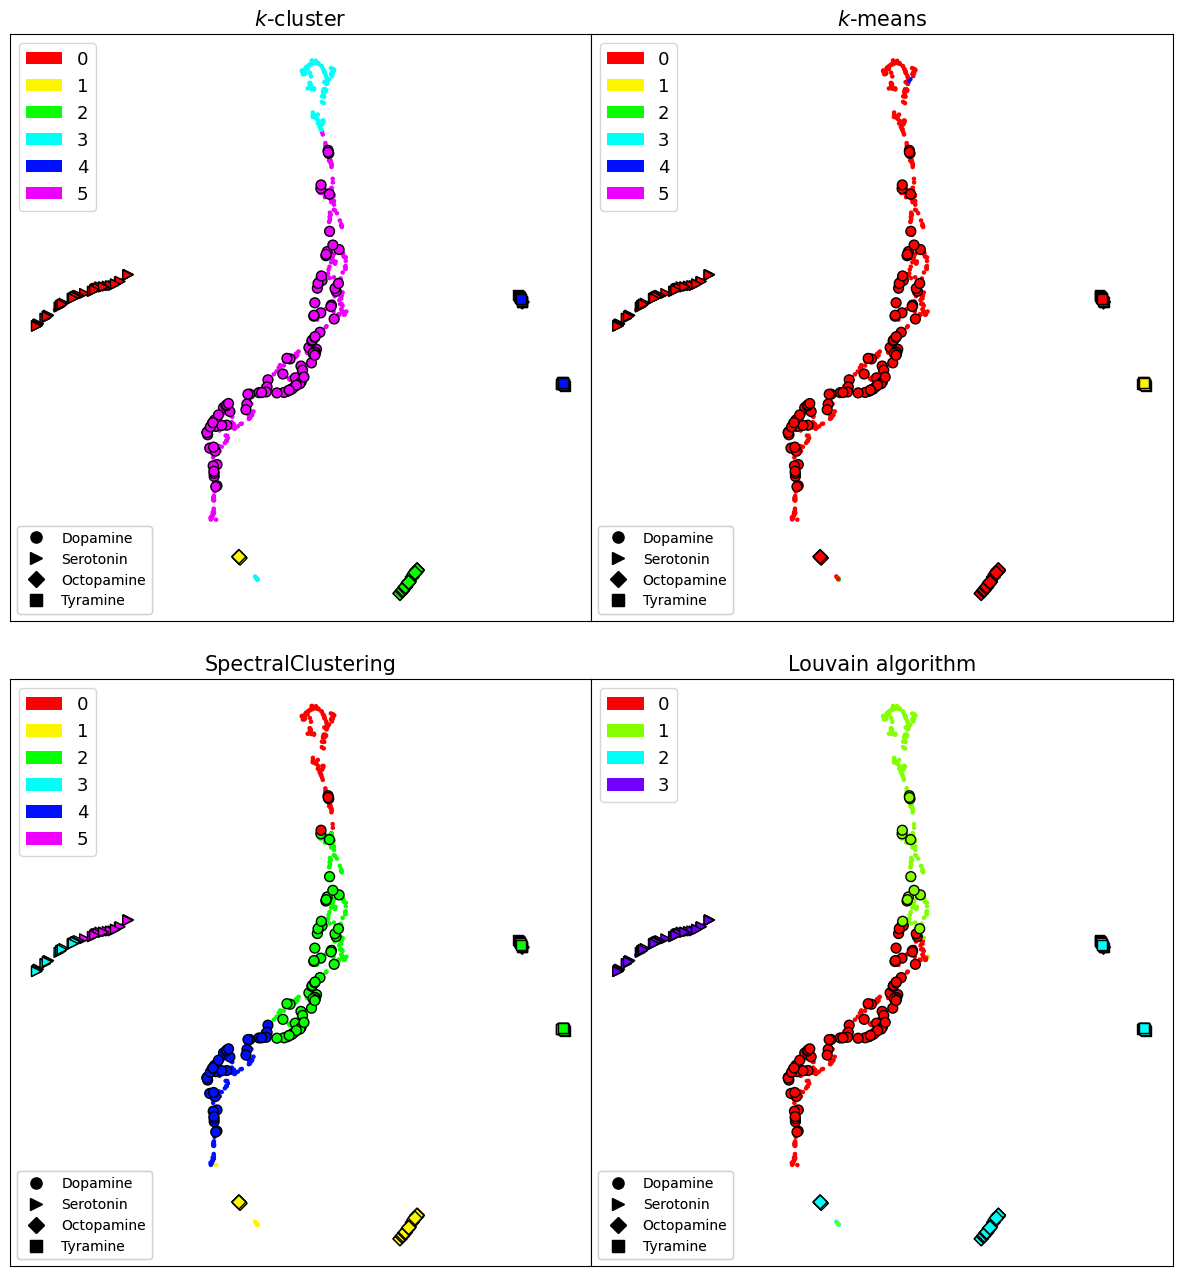

In [15]:
four_methods(iM, metric='cosine', n_clusters=6, k=8, loc_clusterlegend=2, loc_replegend=3)

We see in that the clusters obtained with spectral clustering are not the best (contrary to the case where euclidean distance is used), however, this is due to the fact that the number of clusters was chosen to fit $k$-cluster. By setting parameter `n_clusters` to $9$ instead, we obtain a clustering that fits nicely with the one obtained with $k$-cluster.

Constructed kcluster PD.
Clustered.


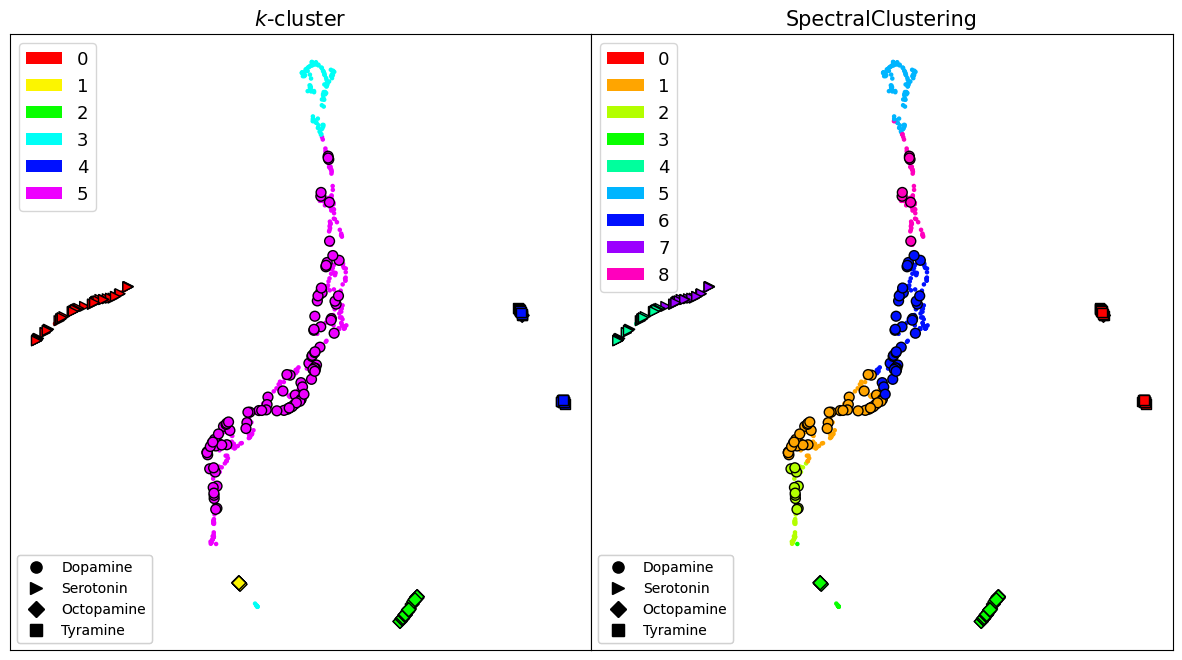

In [18]:
_, (ax1, ax2) = plt.subplots(1,2,figsize=(15,8))
mapper_cos = umap.UMAP(random_state=2400, metric='cosine').fit(iM)
DM = squareform(pdist(iM, metric='cosine'))
sc = SC(n_clusters=9, n_neighbors=8, assign_labels='discretize', affinity='precomputed_nearest_neighbors',random_state=2400).fit(DM)
cluster_ids, _, _ = compute_kcluster(iM, 6, n_neighbors=8, metric='cosine', distance_matrix=DM)
visualize_umap(mapper_cos, cluster_ids, annotate=annotations, legend_text=legend_text, 
                loc_replegend=3, loc_clusterlegend=2,
                title = "$k$-cluster",axis=ax1)
plt.subplots_adjust(wspace=0,hspace=0.1)
visualize_umap(mapper_cos, sc.labels_, annotate=annotations, legend_text=legend_text, 
                loc_clusterlegend=2, loc_replegend=3,
                title = "SpectralClustering", axis=ax2);

### II.3 Clustering on $log$-transformed $iM$ with euclidean distance

To give $k$-means a fighting chance, we $\log$-transform $iM$ by applying $$iM(i,j) \mapsto \ln (1+ 10000 \frac{iM(i,j)}{\sum_k iM(i, k)})$$ to each entry of $iM$ prior to clustering. Note that this is a standard transformation for gene expression data sets, and is the default normalization method in Seurat package (R). Denote the resulting matrix as `lnnorm_iM`.

In [17]:
def log_normalization(matrix):
    new_matrix = np.zeros(matrix.shape)
    for i, row in enumerate(matrix):
        s = row.sum()
        new_matrix[i, :] = np.array([np.log(1 + 10000 * entry / s) for entry in row])
    return new_matrix

iM_lnnorm = log_normalization(iM)

Again, to choose the number of naturally present clusters within the data set according to $k$-cluster filtration for $k=8$, we cluster once using `visualize_kcluster` method and use the persistence diagram from the output to compute and visualize the multiplicative values.

Constructed the distance matrix.
Constructed kcluster PD.
Clustered.


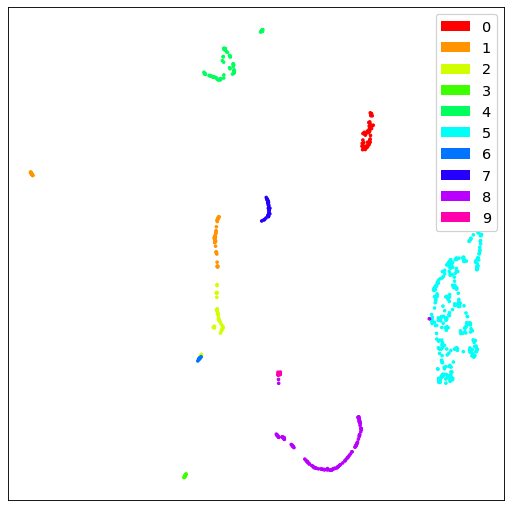

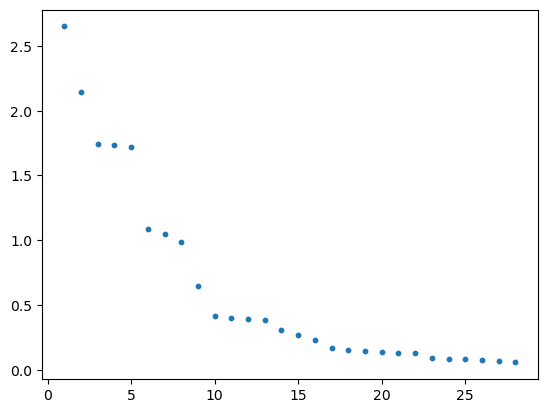

In [19]:
_, ln_mapper, PD, _ = visualize_kcluster(iM_lnnorm, n_clusters=10, n_neighbors=8)
xs = range(1,len(PD))
ys = sorted([entry[1]/entry[0] for entry in PD])[::-1]           # Compute the multiplicative values for each entry
plt.scatter(xs, np.log10(ys[1:]), s=10)                                  # Plot the multiplicative values

We plot the $\log_{10}$ of each multiplicative value against its position in the ordered list, skipping multiplicative value $\infty$, which would be first in the order. Many gaps can be observed, namely between points $1$ and $2$, $2$ and $3$, $5$ and $6$, $8$ and $9$, and $9$ and $10$. Thus, values $2,3,6,9,10$ are all viable choices for `n_clusters` (taking into account $\infty$ as well). 

For consistency sake, we ask all methods (that take the desired number of clusters as input) to return $6$ clusters on $log$-transformed $iM$ with euclidean distance.

Constructed kcluster PD.
Clustered.


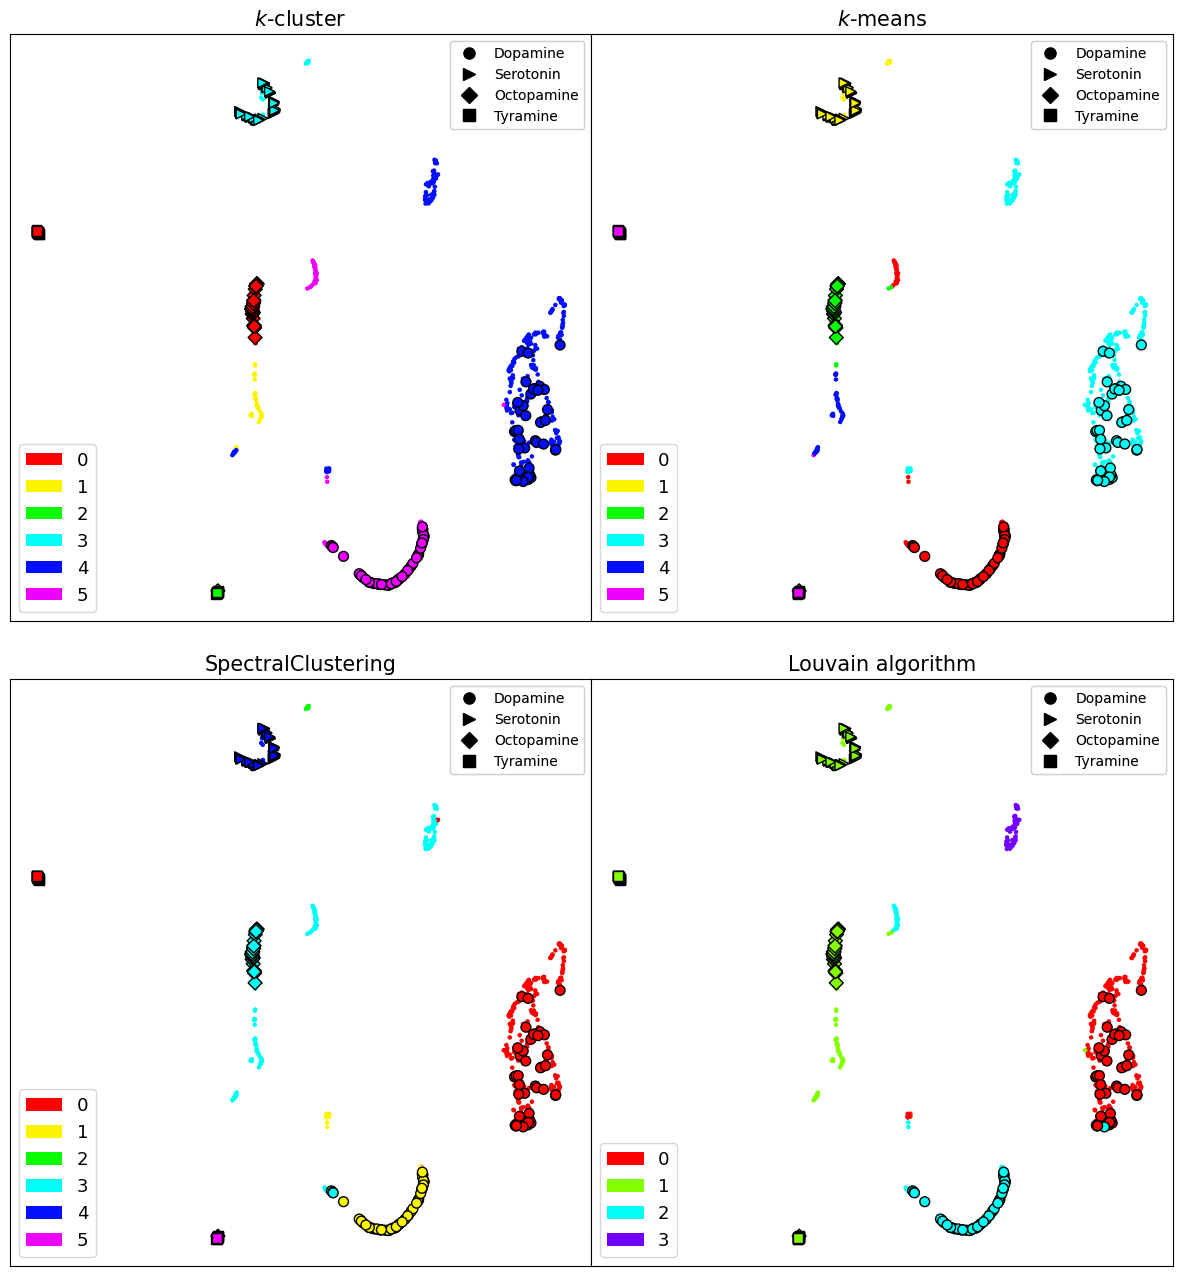

In [20]:
four_methods(iM_lnnorm, metric='euclidean', n_clusters=6, k=8, loc_clusterlegend=3, normalized=True)

## IV. Identification of potential marker genes

We perform marker detection analysis on the "winning" clustering method for each of the settings in the previous sections:
* `C1`: spectral clustering on $iM$ with respect to euclidean distance,
* `C2`: $k$-cluster on $iM$ with respect to cosine similarity,
* `C3`: $k$-means on $\log$-transformed $iM$ with respect to euclidean distance.

First, we determine which cluster belongs to which class. For each of the methods, there is at least one cluster that either contains representatives of more than one class or it does not contain any class representatives. Thus, we compute the percentage of points within each cluster in which a gene is expressed. We base our decision on these percentages for important genes.

### IV.1 Spectral clustering on $iM$ with respect to euclidean distance

Gather clustering results in a dictionary and compute the percentage of points within each cluster for which an important gene is expressed. We summarize the results within a table.

In [61]:
DM = squareform(pdist(iM, metric='euclidean'))
sc = SC(n_clusters=6, n_neighbors=8, assign_labels='discretize', affinity='precomputed_nearest_neighbors',random_state=2400).fit(DM)
C1 = sc.labels_
C1_dict = convert_list_to_dict(C1)
_, df = table_clusterwise_expression(M, C1_dict, range(len(genes)), genes, method = [1]*len(genes))
latex_table, s = latexify_table(df.iloc[important_genes_ids], threshold_max=0, threshold_min=1)
s

method type is list, this is a custom threshold


,0,1,2,3,4,5
Fer2,43.6,64.4,18.8,11.4,0.0,58.0
Trh,0.0,0.3,0.0,75.2,0.0,1.0
ple,0.0,99.7,100.0,1.9,2.9,70.5
Tdc2,100.0,1.0,0.0,1.9,100.0,5.8
DAT,2.6,99.3,100.0,3.8,5.9,98.6
SerT,0.0,0.0,0.0,76.2,0.0,0.0
Tbh,5.1,5.8,12.9,14.3,100.0,1.9


Based on this table and the knowledge of which genes code for which type, we can group clusters belonging to the same class as follows:

In [62]:
C1_modified_dict = {}
C1_modified_dict[0] = C1_dict[1] + C1_dict[5] + C1_dict[2]            # Dopamine
C1_modified_dict[1] = C1_dict[3]                                      # Serotonin
C1_modified_dict[2] = C1_dict[4]                                      # Octopamine
C1_modified_dict[3] = C1_dict[0]                                      # Tyramine

This dictionary now contains the lists of neurons which, according to this clustering, belong to each of the four subtypes: dopaminergic, serotoninergic, octopaminergic and tyraminergic neurons. To see which genes might drive this subtype specialization, we compute the percentage of points within each class for which a specific gene is expressed higher than its median expression on the whole data set. We display only genes which are expressed in more than $75\%$ of one class and less than $10\%$ of another. (We do not display this information for important genes again.)

In [ ]:
not_important = [i for i in range(len(genes)) if i not in important_genes_ids]

In [ ]:
_, df = table_clusterwise_expression(M, C1_modified_dict, range(len(genes)), genes, method = 'median')
_, s = latexify_table(df.iloc[not_important], threshold_max=0.75, threshold_min=0.10)
s

,0,1,2,3
Nep2,13.8,1.0,79.4,33.3
CG15537,28.6,21.0,76.5,7.7
CG13288,9.0,6.7,79.4,17.9
TfAP-2,2.4,10.5,76.5,0.0
asRNA:CR44165,2.4,1.0,97.1,92.3
rgr,1.5,1.9,76.5,46.2
CG10527,8.0,10.5,76.5,12.8
SIFa,2.6,2.9,76.5,35.9
lov,7.3,22.9,76.5,74.4
sdk,24.5,30.5,76.5,2.6


### IV.2 $k$-cluster on $iM$ with respect to cosine similarity

Gather clustering results in a dictionary and compute the percentage of points within each cluster for which an important gene is expressed. We summarize the results within a table.

Constructed the distance matrix.
Constructed kcluster PD.
Clustered.


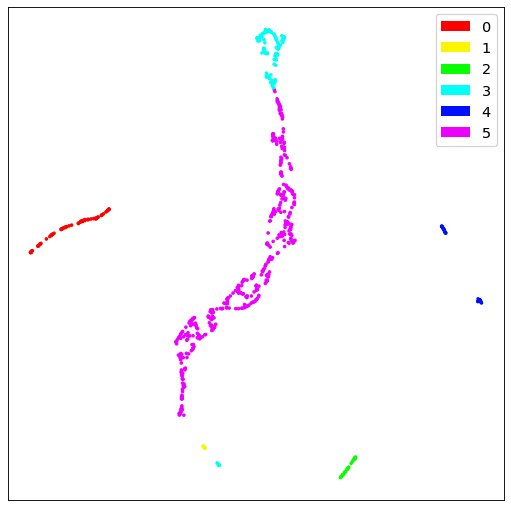

method type is list, this is a custom threshold


In [63]:
C2, _, _, _ = visualize_kcluster(iM, 6, 8, metric='cosine')
C2_dict = convert_list_to_dict(C2)
_, df = table_clusterwise_expression(M, C2_dict, range(len(genes)), genes, method = [1]*len(genes))
latex_table, s = latexify_table(df.iloc[important_genes_ids], threshold_max=0, threshold_min=1)

In [64]:
s

,0,1,2,3,4,5
Fer2,1.2,0.0,0.0,68.3,41.5,52.9
Trh,98.8,0.0,0.0,0.8,0.0,0.4
ple,1.2,0.0,3.3,37.5,0.0,99.8
Tdc2,0.0,58.3,93.3,10.0,97.6,0.6
DAT,0.0,0.0,6.7,91.7,2.4,98.8
SerT,100.0,0.0,0.0,0.0,0.0,0.0
Tbh,11.2,91.7,93.3,2.5,4.9,6.2



Based on this table and the knowledge of which genes code for which type, we can group clusters belonging to the same class as follows:

In [65]:
C2_modified_dict = {}
C2_modified_dict[0] = C2_dict[5]+ C2_dict[3]                          # Dopamine
C2_modified_dict[1] = C2_dict[0]                                      # Serotonin
C2_modified_dict[2] = C2_dict[1] + C2_dict[2]                         # Octopamine
C2_modified_dict[3] = C2_dict[4]                                      # Tyramine

This dictionary now contains the lists of neurons which, according to this clustering, belong to each of the four subtypes: dopaminergic, serotoninergic, octopaminergic and tyraminergic neurons. To see which genes might drive this subtype specialization, we compute the percentage of points within each class for which a specific gene is expressed higher than its median expression on the whole data set. We display only genes which are expressed in more than $70\%$ of one class and less than $10\%$ of another. (We do not display this information for important genes again.)

In [72]:
_, df = table_clusterwise_expression(M, C2_modified_dict, range(len(genes)), genes, method = 'median')
_, s = latexify_table(df.iloc[not_important], threshold_max=0.7, threshold_min=0.1)
s

,0,1,2,3
trv,46.0,76.2,16.7,9.8
CG34354,41.5,72.5,14.3,9.8
asRNA:CR44165,2.3,0.0,81.0,87.8
lov,7.3,23.8,69.0,73.2
Nep1,8.6,31.2,81.0,58.5
ct,9.8,18.8,76.2,58.5
Lim1,44.0,10.0,64.3,92.7
dac,8.0,7.5,73.8,0.0
rdo,32.7,38.8,73.8,7.3
Ddc,50.0,93.8,4.8,2.4


### VI.3 $k$-means on $\log$-transformed $iM$ with respect to euclidean distance

Gather clustering results in a dictionary and compute the percentage of points within each cluster for which an important gene is expressed. We summarize the results within a table.

In [66]:
kmeans_M = np.copy(iM_lnnorm)
est = KMeans(n_clusters=6, random_state=2400)
est.fit(kmeans_M)
C3=est.labels_
C3_dict = convert_list_to_dict(C3)
_, df = table_clusterwise_expression(M, C3_dict, range(len(genes)), genes, method = [1]*len(genes))
latex_table, s = latexify_table(df.iloc[important_genes_ids], threshold_max=0, threshold_min=1)
s

method type is list, this is a custom threshold


,0,1,2,3,4,5
Fer2,0.0,1.2,4.3,75.3,73.2,42.1
Trh,0.0,98.8,0.0,0.8,0.0,0.0
ple,98.0,1.2,2.1,96.2,0.0,0.0
Tdc2,0.7,0.0,78.7,1.0,19.6,97.4
DAT,98.0,0.0,4.3,99.2,87.5,0.0
SerT,0.0,100.0,0.0,0.0,0.0,0.0
Tbh,9.2,11.2,85.1,4.3,1.8,5.3


Based on this table and the knowledge of which genes code for which type, we can group clusters belonging to the same class as follows:

In [67]:
C3_modified_dict = {}
C3_modified_dict[0] = C3_dict[0] + C3_dict[3] + C3_dict[4]            # Dopamine
C3_modified_dict[1] = C3_dict[1]                                      # Serotonin
C3_modified_dict[2] = C3_dict[2]                                      # Octopamine
C3_modified_dict[3] = C3_dict[5]                                      # Tyramine

This dictionary now contains the lists of neurons which, according to this clustering, belong to each of the four subtypes: dopaminergic, serotoninergic, octopaminergic and tyraminergic neurons. To see which genes might drive this subtype specialization, we compute the percentage of points within each class for which a specific gene is expressed higher than its median expression on the whole data set. We display only genes which are expressed in more than $70\%$ of one class and less than $10\%$ of another. (We do not display this information for important genes again.)

In [71]:
_, df = table_clusterwise_expression(M, C3_modified_dict, range(len(genes)), genes, method = 'median')
_, s = latexify_table(df.iloc[not_important], threshold_max=0.7, threshold_min=0.1)
s

,0,1,2,3
trv,46.0,76.2,21.3,5.3
CG34354,41.5,72.5,17.0,7.9
asRNA:CR44165,2.5,0.0,76.6,86.8
lov,7.3,23.8,66.0,73.7
Nep1,8.7,31.2,76.6,57.9
ct,10.0,18.8,72.3,55.3
Lim1,44.2,10.0,63.8,92.1
dac,7.7,7.5,70.2,0.0
Ddc,50.0,93.8,6.4,2.6


## -I. Other plots

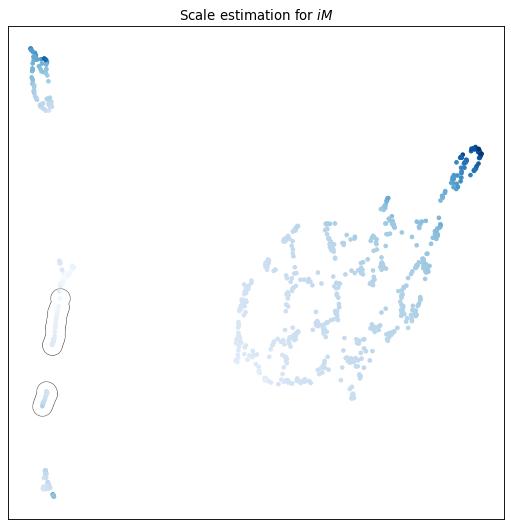

In [22]:
# Scale estimation for monoaminergic neurons
fig, ax = plt.subplots(figsize=(8,8), dpi=80)
size_list = [False]*len(iM)
for i in representatives['Tyramine']:
    size_list[i] = True
ax.scatter(*mapper.embedding_[representatives['Tyramine'],:].T, c='white', marker='o',edgecolor='gray',s=300)
ax.scatter(*mapper.embedding_[representatives['Tyramine'],:].T, c='white', marker='o',edgecolor=None,s=250)
ax.scatter(*mapper.embedding_.T, c = (np.sqrt(np.linalg.norm(iM,axis=1))), cmap='Blues', s=10)
ax.tick_params(left = False, right = False, labelleft = False, labelbottom = False, bottom = False) 
ax.set_title("Scale estimation for $iM$");